In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from utils.data import get_data
from utils.train_val_test import setup_seed
import pandas as pd

SEED = setup_seed()

class Omics(Dataset):
    def __init__(self, fold_path, metabric_path, mode=["CNA", "RNA", "CLI"]):
        # Get pre-processed data
        omics = get_data(fold_path, metabric_path)

        self.mode = mode
        
        rna = torch.tensor(omics["rnanp"], dtype=torch.float)
        cna = torch.tensor(omics["cnanp"], dtype=torch.float)
        cli = torch.tensor(omics["clin"], dtype=torch.float)

        self.omics_values = {}
        self.omics_values["CNA"] = cna
        self.omics_values["RNA"] = rna
        self.omics_values["CLI"] = cli

        self.pam50 = torch.tensor(omics["pam50np"], dtype=torch.int)
        self.pam50_labels = omics["pam50"]

    def get_omics_data(self, omics_name):
        return self.omics_values[omics_name]
        
    def get_input_dims(self, omics_name):
        return self.omics_values[omics_name].size()[1]

    def __len__(self):
        return len(self.pam50)

    def __getitem__(self, idx):
        return [self.omics_values[omics_name][idx] for omics_name in self.mode], self.pam50[idx]

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Literal
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.logging import log
from utils.train_val_test import Early_Stopping
from abc import ABC, abstractmethod
from networks.losses import compute_vae_loss

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
_REGULARISATION = Literal["mmd", "kld"]


class FC_layer(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        normalization: bool = True,
        d_p=0,
        activation_layer=None,
    ):
        """
        Construct a fully-connected block

        Parameters:
            input_dim (int)         -- the dimension of the input tensor
            output_dim (int)        -- the dimension of the output tensor
            normalization (bool)    -- need normalization or not
            dropout_p (float)       -- probability of an element to be zeroed in a dropout layer
            activation_layer (nn)   -- activation function to in the FC block

        source @https://github.com/zhangxiaoyu11/OmiEmbed
        """
        super().__init__()

        self.fc_block = [nn.Linear(input_dim, output_dim)]

        if normalization:
            self.fc_block.append(nn.BatchNorm1d(output_dim))

        if 0 < d_p <= 1:
            self.fc_block.append(nn.Dropout(p=d_p))

        if activation_layer is not None:
            self.fc_block.append(activation_layer)

        self.fc_block = nn.Sequential(*self.fc_block)

    def forward(self, x):
        y = self.fc_block(x)
        return y


_MODES = Literal["CNA", "RNA", "CLI"]


class VAE(nn.Module):
    def __init__(
        self,
        params,
        omics_index=None,
        early_stopping=None,
    ):
        super().__init__()

        self.early_stopping = early_stopping
        self.beta = params.beta
        self.regularisation = params.regularisation
        self.loss_fn = params.loss_fn
        self.omics_index = omics_index

        self.encoder_dense = FC_layer(
            params.input_dim,
            params.dense_dim,
            params.normalization,
            params.d_p,
            params.activation_fn,
        )

        self.encoder_mean = nn.Linear(params.dense_dim, params.latent_dim)
        self.encoder_log_var = nn.Linear(params.dense_dim, params.latent_dim)

        self.decoder_dense = FC_layer(
            params.latent_dim,
            params.dense_dim,
            params.normalization,
            params.d_p,
            params.activation_fn,
        )
        self.decoder_output = FC_layer(
            params.dense_dim,
            params.input_dim,
            False,
            0,
            params.output_activation_fn,
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """
        Xavier uniform model initialisation
        @source https://stackoverflow.com/questions/49433936/how-do-i-initialize-weights-in-pytorch
        """
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            module.bias.data.fill_(0.01)

    def reparameterize(self, mean, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mean)

        return mean

    def forward(self, x):
        if self.omics_index is not None:
            x = x[self.omics_index]

        original_x = x.to(DEVICE)

        x = self.encoder_dense(original_x)

        latent_mean = self.encoder_mean(x)
        latent_log_var = self.encoder_log_var(x)

        z = self.reparameterize(latent_mean, latent_log_var)

        reconstructed_x = self.decoder_dense(z)
        reconstructed_x = self.decoder_output(reconstructed_x)

        return original_x, reconstructed_x, latent_mean, latent_log_var, z

    def train_loop(self, dataloader, optimizer, epochs):
        self.train()

        for epoch in range(0, epochs):
            loss_sum = 0.0

            for batch_idx, (x, y) in enumerate(dataloader):
                (
                    original_x,
                    reconstructed_x,
                    latent_mean,
                    latent_log_var,
                    z,
                ) = self.forward(x)
                loss = compute_vae_loss(
                    self.loss_fn,
                    self.regularisation,
                    self.beta,
                    original_x,
                    reconstructed_x,
                    latent_mean,
                    latent_log_var,
                )

                loss_sum += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_loss = loss_sum / len(dataloader)

            val_loss = self.validate(dataloader)

            if epoch % 20 == 0:
                log(
                    Epoch=epoch,
                    Train=train_loss,
                    Val=val_loss,
                )

            if self.early_stopping is not None and self.early_stopping.check(val_loss):
                print(
                    f"Early stopped at epoch: {epoch}, Best Val: {self.early_stopping.best_loss:.4f}"
                )

                # torch.save(model.state_dict(), "rnaVAE.pth")
                break

    @torch.no_grad()
    def validate(self, dataloader):
        self.eval()
        loss_sum = 0.0

        for batch_idx, (x, y) in enumerate(dataloader):
            original_x, reconstructed_x, latent_mean, latent_log_var, z = self.forward(
                x
            )
            loss = compute_vae_loss(
                self.loss_fn,
                self.regularisation,
                self.beta,
                original_x,
                reconstructed_x,
                latent_mean,
                latent_log_var,
            )
            loss_sum += loss.item()

        return loss_sum / len(dataloader)

    @torch.no_grad()
    def get_latent_space(self, dataloader):
        self.eval()
        latent_space = None
        gt = []

        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(dataloader):
                return_values = self.forward(x)
                z = return_values[-1]
                if latent_space is not None:
                    latent_space = torch.cat((latent_space, z), dim=0)
                else:
                    latent_space = z

                gt.extend(y.cpu().numpy())

        return latent_space.cpu().numpy(), gt


class Params_VAE:
    def __init__(
        self,
        input_dim,
        dense_dim,
        latent_dim,
        lr=0.001,
        batch_size=64,
        epochs=150,
        loss_fn=nn.MSELoss(),
        normalization=True,
        d_p=0.2,
        activation_fn=nn.ELU(),
        output_activation_fn=None,
        beta=50,
        regularisation: _REGULARISATION = "mmd",
    ):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.loss_fn = loss_fn
        self.input_dim = input_dim
        self.dense_dim = dense_dim
        self.latent_dim = latent_dim
        self.normalization = normalization
        self.d_p = d_p
        self.activation_fn = activation_fn
        self.beta = beta
        self.regularisation = regularisation
        self.output_activation_fn = output_activation_fn


class H_VAE(VAE):
    def __init__(self, input_VAEs, params, early_stopping=None):
        super().__init__(params, early_stopping=early_stopping)

        self.input_VAEs = input_VAEs
        self.params = params

    def forward(self, x):
        latent_omics = []

        with torch.no_grad():
            for i in range(len(x)):
                self.input_VAEs[i].eval()
                latent_data = self.input_VAEs[i].forward(x)
                z = latent_data[-1]
                latent_omics.append(z)

        latent_x = torch.cat(latent_omics, dim=1)

        x, reconstructed, latent_mean, latent_log_var, z = super().forward(latent_x)

        return latent_x, reconstructed, latent_mean, latent_log_var, z

    def train_loop(self, dataloader, optimizers):
        for i in range(len(self.input_VAEs)):
            print(f"Training VAE {i+1}")
            self.input_VAEs[i] = self.input_VAEs[i].to(DEVICE)
            self.input_VAEs[i].train_loop(dataloader, optimizers[i], self.params.epochs)

        print("Training H_VAE")
        super().train_loop(dataloader, optimizers[-1], self.params.epochs)


In [3]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import os
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import torch.nn as nn

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Benchmark_Classifier:
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.classifiers = [
            GaussianNB(),
            SVC(
                C=1.5,
                kernel="rbf",
                random_state=SEED,
                gamma="auto",
            ),
            RandomForestClassifier(
                n_estimators=50,
                random_state=SEED,
                max_features=0.5,
            ),
        ]

    def train(self, dataloader):
        latent_train, gt_train = self.model.get_latent_space(dataloader)
        print("Training Classifiers")

        for cls in self.classifiers:
            cls.fit(latent_train, gt_train)

        return self.evaluate(dataloader)

    def evaluate(self, dataloader):
        latent, gt = self.model.get_latent_space(dataloader)
        acc_scores = []
        for cls in self.classifiers:
            predictions = cls.predict(latent)
            acc_scores.append(accuracy_score(gt, predictions))

        return acc_scores

In [4]:
import os
import numpy as np
from utils.train_val_test import Early_Stopping

metabric_path = "data/MBdata_33CLINwMiss_1KfGE_1KfCNA.csv"

N_FOLDS = 1
fold_dir = "data/5-fold_pam50stratified/"
file_name = "MBdata_33CLINwMiss_1KfGE_1KfCNA"

accTrain_list = []
accTest_list = []

epochs = 40

params = Params_VAE(256, 256, 64, epochs=epochs)
early_stopping = Early_Stopping()

omics_types = ["CNA", "RNA"]


for k in range(1, N_FOLDS + 1):
    train_data_path = os.path.join(fold_dir, f"fold{k}", file_name + "_train.csv")
    test_data_path = os.path.join(fold_dir, f"fold{k}", file_name + "_test.csv")

    train_omics = Omics(train_data_path, metabric_path, mode=omics_types)
    test_omics = Omics(test_data_path, metabric_path, mode=omics_types)

    train_dataloader = DataLoader(
        train_omics, batch_size=params.batch_size, shuffle=False
    )
    test_dataloader = DataLoader(
        test_omics, batch_size=params.batch_size, shuffle=False
    )

    input_VAEs = []
    optimizers = []

    for i in range(len(omics_types)):
        vae_params = Params_VAE(
            train_omics.get_input_dims(omics_types[i]),
            params.dense_dim,
            params.dense_dim // 2,
            epochs=epochs
        )
        if omics_types[i] == "CNA" or omics_types[i] == "CLI":
            vae_params.loss_fn = nn.BCEWithLogitsLoss(reduction="mean")
        if omics_types[i] == "RNA":
            vae_params.loss_fn = nn.MSELoss(reduction="mean")

        input_VAEs.append(VAE(vae_params, omics_index=i, early_stopping=early_stopping))

        optimizers.append(
            torch.optim.Adam(input_VAEs[i].parameters(), lr=vae_params.lr)
        )

    hvae = H_VAE(input_VAEs, params, early_stopping).to(DEVICE)

    optimizers.append(torch.optim.Adam(hvae.parameters(), lr=params.lr))
    hvae.train_loop(train_dataloader, optimizers)

    classifier = Benchmark_Classifier(hvae)
    accTrain = classifier.train(train_dataloader)
    accTest = classifier.evaluate(test_dataloader)

    print(f"\nFold {k} - Train Acc: {accTrain}, Test Acc: {accTest}\n")

    accTrain_list.append(accTrain)
    accTest_list.append(accTest)

meanAccTrain = np.array(accTrain_list).mean(axis=0)
meanAccTest = np.array(accTest_list).mean(axis=0)
print(f"Overall - Mean Train Acc: {meanAccTrain}, Mean Test Acc: {meanAccTest}")

Training VAE 1
Epoch: 000, Train: 0.7012, Val: 0.7061
Early stopped at epoch: 19, Best Val: 0.6407
Training VAE 2
Epoch: 000, Train: 0.2620, Val: 0.1011
Epoch: 020, Train: 0.0072, Val: 0.0071
Training H_VAE
Epoch: 000, Train: 1.4899, Val: 0.7827
Early stopped at epoch: 4, Best Val: 0.0056
Training Classifiers

Fold 1 - Train Acc: [0.5025252525252525, 0.9299242424242424, 1.0], Test Acc: [0.5126262626262627, 0.5808080808080808, 0.6388888888888888]

Overall - Mean Train Acc: [0.50252525 0.92992424 1.        ], Mean Test Acc: [0.51262626 0.58080808 0.63888889]


/home/davide/Desktop/Projects/Multi-omics-data-integration-with-DL-approaches/GATO/utils/data.py:21: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=z[:, 0], y=z[:, 1], hue=y, palette=sns.color_palette("bright"))


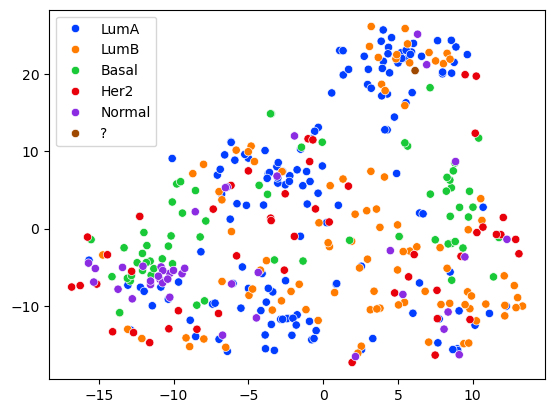

In [5]:
from utils.data import plot_latent_space

latent, gt = hvae.get_latent_space(test_dataloader)
plot_latent_space(latent, test_omics.pam50_labels) 